##Install packages

In [1]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 50.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 7.4 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=95589a6ce36e74483d6f86977e7835

# Import libraries

In [2]:
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

#Detectron 2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer

In [3]:
!ls
!unzip "Text_Detection_Dataset_COCO_Format.zip"

sample_data  Text_Detection_Dataset_COCO_Format.zip
Archive:  Text_Detection_Dataset_COCO_Format.zip
   creating: Text_Detection_Dataset_COCO_Format/
   creating: Text_Detection_Dataset_COCO_Format/train/
  inflating: Text_Detection_Dataset_COCO_Format/train/0.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/1.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/10.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/100.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/101.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/102.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/103.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/104.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/105.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/106.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/107.jpeg  
  inflating: Text_Detection_Dataset_COCO_Format/train/108.jpeg  
  inflating: Text_De

##Preparing the data


In [8]:
import json
from detectron2.structures import BoxMode
def get_board_dicts(imgdir):
    json_file = imgdir+"/dataset.json"
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in dataset_dicts:
        filename = i["file_name"] 
        i["file_name"] = imgdir+"/"+filename 
        for j in i["annotations"]:
            j["bbox_mode"] = BoxMode.XYWH_ABS
            j["category_id"] = int(j["category_id"])
    return dataset_dicts


##Registering the data

In [ ]:
from detectron2.data import MetadataCatalog,DatasetCatalog
for d in ["train","val"]:
  DatasetCatalog.register("boardetect_" + d, lambda d=d: get_board_dicts("Text_Detection_Dataset_COCO_Format/" + d))
  MetadataCatalog.get("boardetect_" + d).set(thing_classes=["HINDI","ENGLISH","OTHER"])
board_metadata = MetadataCatalog.get("boardetect_train")

## Visualize

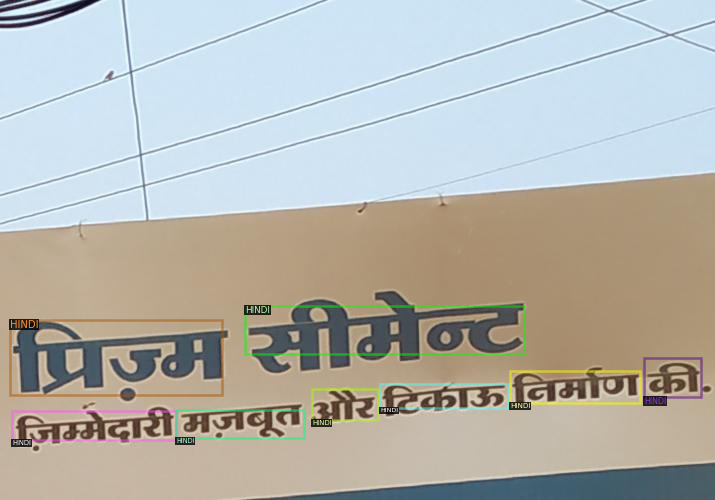

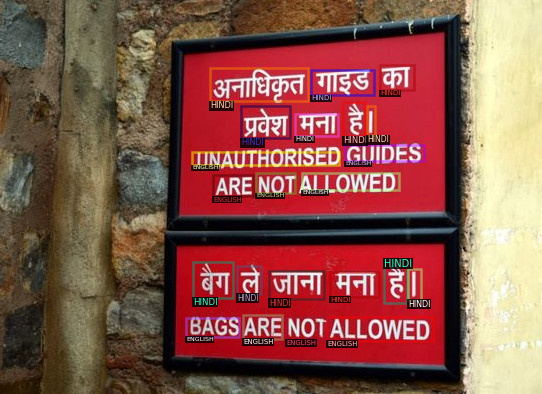

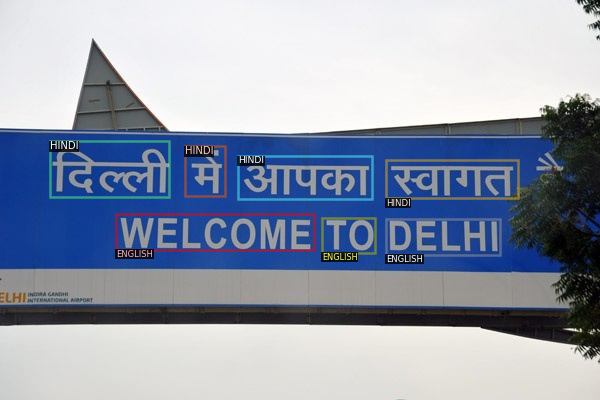

In [10]:
dataset_dicts = get_board_dicts("Text_Detection_Dataset_COCO_Format/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])



##training

In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_val",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
cfg.SOLVER.MAX_ITER = 1500   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/16 06:19:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:02, 67.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[08/16 06:19:31 d2.engine.train_loop]: Starting training from iteration 0
[08/16 06:19:49 d2.utils.events]:  eta: 0:22:09  iter: 19  total_loss: 2.015  loss_cls: 0.967  loss_box_reg: 0.464  loss_rpn_cls: 0.399  loss_rpn_loc: 0.093  time: 0.9077  data_time: 0.0288  lr: 0.000250  max_mem: 4958M
[08/16 06:20:07 d2.utils.events]:  eta: 0:22:01  iter: 39  total_loss: 1.402  loss_cls: 0.500  loss_box_reg: 0.722  loss_rpn_cls: 0.075  loss_rpn_loc: 0.070  time: 0.9067  data_time: 0.0161  lr: 0.000500  max_mem: 4958M
[08/16 06:20:26 d2.utils.events]:  eta: 0:22:00  iter: 59  total_loss: 1.272  loss_cls: 0.423  loss_box_reg: 0.714  loss_rpn_cls: 0.039  loss_rpn_loc: 0.054  time: 0.9112  data_time: 0.0168  lr: 0.000749  max_mem: 4958M
[08/16 06:20:44 d2.utils.events]:  eta: 0:21:42  iter: 79  total_loss: 1.073  loss_cls: 0.350  loss_box_reg: 0.578  loss_rpn_cls: 0.029  loss_rpn_loc: 0.041  time: 0.9160  data_time: 0.0213  lr: 0.000999  max_mem: 4958M
[08/16 06:21:04 d2.utils.events]:  eta: 0:21:3

##Inference from the model

In [17]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

dataset_dicts = get_board_dicts("Text_Detection_Dataset_COCO_Format/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=board_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

##Evaluation

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("boardetect_val", cfg, False, output_dir="/output/")
val_loader = build_detection_test_loader(cfg, "boardetect_val")

#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[08/16 07:11:06 d2.data.common]: Serializing 27 elements to byte tensors and concatenating them all ...
[08/16 07:11:06 d2.data.common]: Serialized dataset takes 0.01 MiB
[08/16 07:11:06 d2.evaluation.evaluator]: Start inference on 27 images
[08/16 07:11:07 d2.evaluation.evaluator]: Inference done 11/27. 0.1032 s / img. ETA=0:00:01
[08/16 07:11:09 d2.evaluation.evaluator]: Total inference time: 0:00:02.374180 (0.107917 s / img per device, on 1 devices)
[08/16 07:11:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.101574 s / img per device, on 1 devices)
[08/16 07:11:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/16 07:11:09 d2.evaluation.coco_evaluation]: Saving results to /output/coco_instances_results.json
[08/16 07:11:09 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (

OrderedDict([('bbox',
              {'AP': 21.453863874582265,
               'AP-ENGLISH': 13.97689768976898,
               'AP-HINDI': 50.38469393397782,
               'AP-OTHER': 0.0,
               'AP50': 37.24037005134054,
               'AP75': 20.210447469320425,
               'APl': 18.55284907911366,
               'APm': 36.95997577364283,
               'APs': 18.882425742574256})])